In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Prepare data

In [2]:
db = sqlite3.connect("BaseballStats.db")

In [3]:
NOT_DRAFTED_VALUE = 1000
NOT_INIT_DRAFT_VALUE = 100

In [4]:
D_TYPE = torch.float32

In [5]:
levelMap = {1:0,11:1,12:2,13:3,14:4,15:5,16:6,17:7}

In [6]:
cursor = db.cursor()
hitters = cursor.execute('''
                         SELECT mp.mlbId, mp.ageAtSigningYear, p.draftPick
                         FROM Model_Players AS mp
                         INNER JOIN Player as p ON mp.mlbId = p.mlbId
                         WHERE mp.isHitter='1'
                         ORDER BY mp.mlbId
                         ''').fetchall()

pitchers = cursor.execute('''
                         SELECT mp.mlbId, mp.ageAtSigningYear, p.draftPick
                         FROM Model_Players AS mp
                         INNER JOIN Player as p ON mp.mlbId = p.mlbId
                         WHERE mp.isPitcher='1'
                         ''').fetchall()

Get the mean/std dev of columns to do input normalization

In [7]:
def Generate_Normalized_Stats(db, stats, table):
    df = pd.read_sql_query(f"SELECT {stats} FROM {table}", db)
    std_scaler = StandardScaler()
    scaled_stats = std_scaler.fit_transform(df)
    return scaled_stats, std_scaler

In [8]:
def Plot_Explained_Var(stat_type, explained_var, num_stats):
    plt.plot(range(1,num_stats + 1), explained_var, marker='o')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Explained Variance")
    plt.title(F"Explained Variance Ratio for Player {stat_type}")

In [9]:
# query = '''
#                              SELECT Month, Age, PA, Level, 
#                              ParkRunFactor, ParkHRFactor, avgRatio, obpRatio,
#                              isoRatio, wOBARatio, sbRateRatio, sbPercRatio,
#                              hrPercRatio, bbPercRatio, kPercRatio,
#                              PercC, Perc1B, Perc2B, Perc3B, PercSS, PercLF, PercCF, PercRF, PercDH
#                              FROM Model_HitterStats'''

# stats_to_query = '''
#                     Age, PA, Level, 
#                     wOBARatio, 
#                     hrPercRatio, bbPercRatio, kPercRatio,
#                     PercC, Perc1B, Perc2B, Perc3B, PercSS, PercLF, PercCF, PercRF, PercDH
#                     '''

fielding_stats_query = "PercC, Perc1B, Perc2B, Perc3B, PercSS, PercLF, PercCF, PercRF, PercDH"
hitting_stats_query = "avgRatio, obpRatio, isoRatio, wOBARatio, hrPercRatio, bbPercRatio, kPercRatio"
stealing_stats_query = "sbRateRatio, sbPercRatio"
park_factors_query = "ParkRunFactor, ParkHRFactor"
hitter_person_query = "AGE, PA, Level"

hitter_table = "Model_HitterStats"
pitcher_table = "Model_PitcherStats"

# query = f'''
#                              SELECT {stats_to_query}
#                              FROM Model_HitterStats'''

# hitterDf = pd.read_sql_query(query, db)


# means = hitterDf.mean().tolist()
# stds = hitterDf.std().tolist()

In [10]:
np.set_printoptions(precision=2, linewidth=300, floatmode='fixed')

Determine PCA For Fielding Stats

In [11]:
ndarray_fielding, scaler_fielding = Generate_Normalized_Stats(db, fielding_stats_query, hitter_table)

In [12]:
explained_var = []
for n in range(ndarray_fielding.shape[1]):
    pca = PCA(n + 1)
    pca.fit_transform(ndarray_fielding)
    explained_var.append(np.sum(pca.explained_variance_ratio_))
    
print("   %C    %1B    %2B   %3B   %SS   %LF   %CF   %RF   %DH")
print(pca.components_)
print(pca.explained_variance_ratio_)

   %C    %1B    %2B   %3B   %SS   %LF   %CF   %RF   %DH
[[-0.11 -0.05 -0.40 -0.32 -0.38  0.48  0.34  0.46  0.13]
 [ 0.52  0.42 -0.32 -0.07 -0.37 -0.14 -0.30 -0.20  0.39]
 [ 0.68 -0.42 -0.09 -0.33  0.11 -0.17  0.25 -0.02 -0.37]
 [-0.09  0.36 -0.36  0.42 -0.16 -0.30  0.53 -0.10 -0.40]
 [ 0.17 -0.54  0.05  0.66 -0.46  0.12 -0.12  0.04  0.06]
 [ 0.05  0.00 -0.53  0.23  0.42 -0.02 -0.47  0.48 -0.20]
 [ 0.01  0.16  0.41 -0.12 -0.37 -0.48 -0.12  0.63 -0.16]
 [-0.12 -0.30 -0.19  0.03  0.21 -0.54  0.30  0.14  0.64]
 [-0.45 -0.33 -0.34 -0.32 -0.34 -0.30 -0.33 -0.31 -0.23]]
[0.16 0.14 0.13 0.12 0.11 0.11 0.11 0.10 0.02]


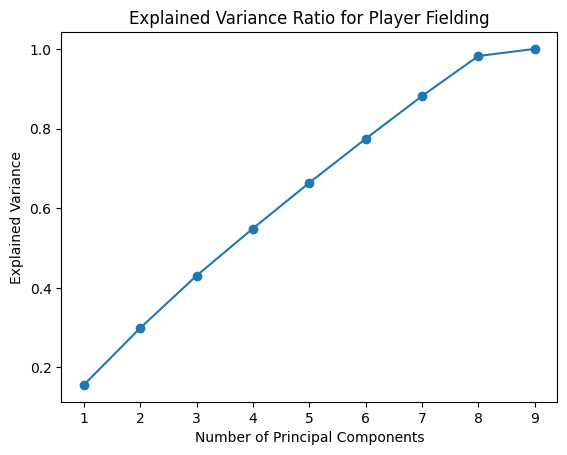

In [13]:
Plot_Explained_Var("Fielding", explained_var, ndarray_fielding.shape[1])

In [14]:
FIELDING_PCA_COMPONENTS = 8
pca_fielding = PCA(FIELDING_PCA_COMPONENTS)
pca_fielding.fit(ndarray_fielding)

PCA(n_components=8)

Determine PCA For Hitting Stats

In [15]:
ndarray_hitting, scaler_hitting = Generate_Normalized_Stats(db, hitting_stats_query, hitter_table)

In [16]:
explained_var = []
for n in range(ndarray_hitting.shape[1]):
    pca = PCA(n + 1)
    pca.fit_transform(ndarray_hitting)
    explained_var.append(np.sum(pca.explained_variance_ratio_))
    
print("   avg,  obp,  iso,  woba,  hr%,  bb%,  k%")
print(pca.components_)
print(pca.explained_variance_ratio_)

   avg,  obp,  iso,  woba,  hr%,  bb%,  k%
[[ 0.46  0.48  0.37  0.53  0.26  0.17 -0.21]
 [-0.13 -0.29  0.51 -0.03  0.62 -0.35  0.35]
 [-0.34  0.10  0.07 -0.00  0.13  0.81  0.44]
 [-0.36 -0.19  0.13 -0.16  0.31  0.25 -0.79]
 [ 0.16  0.15 -0.72 -0.08  0.66 -0.02  0.04]
 [ 0.70 -0.52  0.08 -0.32  0.02  0.35 -0.00]
 [ 0.08  0.59  0.24 -0.77  0.02 -0.07  0.00]]
[0.50 0.22 0.14 0.10 0.03 0.01 0.00]


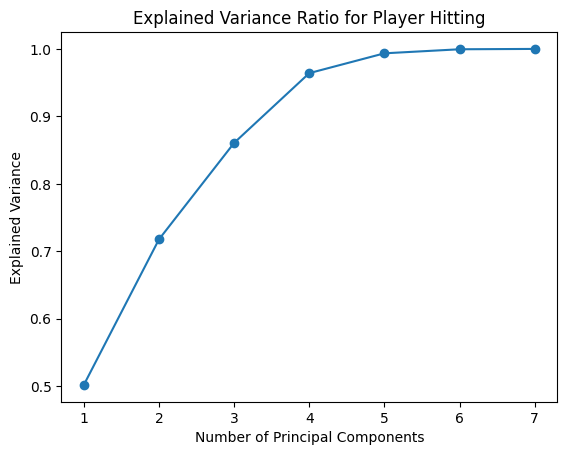

In [17]:
Plot_Explained_Var("Hitting", explained_var, ndarray_hitting.shape[1])

In [18]:
HITTING_PCA_COMPONENTS = 4
pca_hitting = PCA(HITTING_PCA_COMPONENTS)
pca_hitting.fit(ndarray_hitting)

PCA(n_components=4)

Determine PCA For Stealing Stats

In [19]:
ndarray_stealing, scaler_stealing = Generate_Normalized_Stats(db, stealing_stats_query, hitter_table)

In [20]:
explained_var = []
for n in range(ndarray_stealing.shape[1]):
    pca = PCA(n + 1)
    pca.fit_transform(ndarray_stealing)
    explained_var.append(np.sum(pca.explained_variance_ratio_))
    
print(" sbRate,  sb%")
print(pca.components_)
print(pca.explained_variance_ratio_)

 sbRate,  sb%
[[ 0.71  0.71]
 [ 0.71 -0.71]]
[0.63 0.37]


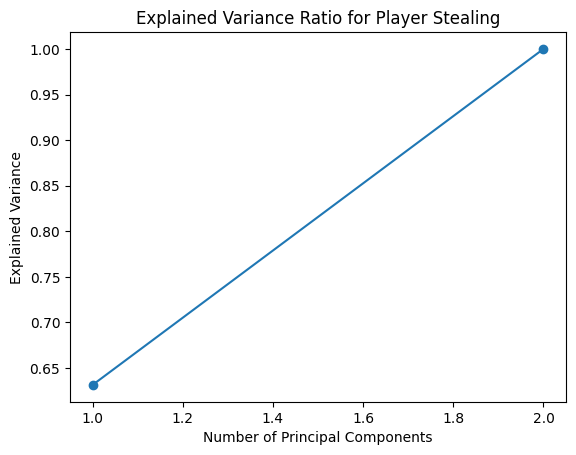

In [21]:
Plot_Explained_Var("Stealing", explained_var, ndarray_stealing.shape[1])

In [22]:
STEALING_PCA_COMPONENTS = 1
pca_stealing = PCA(STEALING_PCA_COMPONENTS)
pca_stealing.fit(ndarray_stealing)

PCA(n_components=1)

Determine PCA For Park Factors

In [23]:
ndarray_hitting_parkfactors, scaler_hitting_parkfactors = Generate_Normalized_Stats(db, park_factors_query, hitter_table)

In [24]:
explained_var = []
for n in range(ndarray_hitting_parkfactors.shape[1]):
    pca = PCA(n + 1)
    pca.fit_transform(ndarray_hitting_parkfactors)
    explained_var.append(np.sum(pca.explained_variance_ratio_))
    
print("  Run,    HR")
print(pca.components_)
print(pca.explained_variance_ratio_)

  Run,    HR
[[ 0.71  0.71]
 [-0.71  0.71]]
[0.80 0.20]


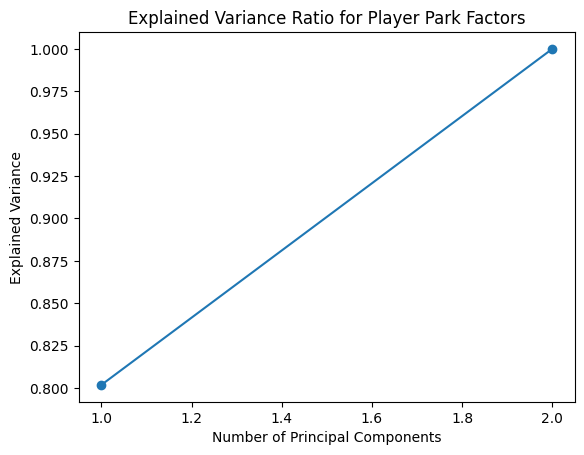

In [25]:
Plot_Explained_Var("Park Factors", explained_var, ndarray_hitting_parkfactors.shape[1])

In [26]:
HITTING_PARKFACTORS_COMPONENTS = 1
pca_hitting_parkfactors = PCA(HITTING_PARKFACTORS_COMPONENTS)
pca_hitting_parkfactors.fit(ndarray_hitting_parkfactors)

PCA(n_components=1)

Determine PCA For Player Components

In [27]:
ndarray_player_hitter, scaler_player_hitter = Generate_Normalized_Stats(db, hitter_person_query, hitter_table)

In [28]:
explained_var = []
for n in range(ndarray_player_hitter.shape[1]):
    pca = PCA(n + 1)
    pca.fit_transform(ndarray_player_hitter)
    explained_var.append(np.sum(pca.explained_variance_ratio_))
    
print("   age,   pa,  level")
print(pca.components_)
print(pca.explained_variance_ratio_)

   age,   pa,  level
[[ 0.66  0.33 -0.68]
 [-0.31  0.94  0.15]
 [ 0.69  0.11  0.72]]
[0.63 0.30 0.07]


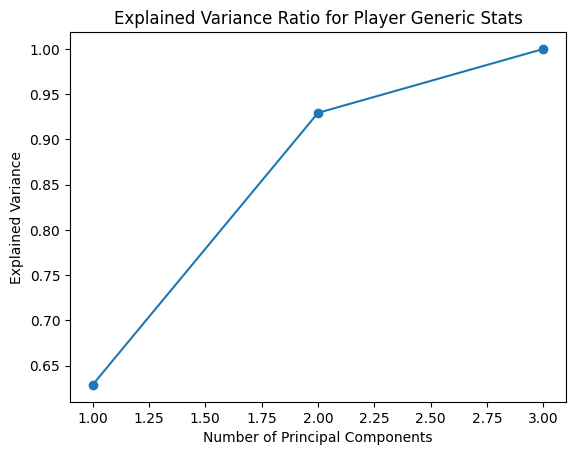

In [29]:
Plot_Explained_Var("Generic Stats", explained_var, ndarray_player_hitter.shape[1])

In [30]:
PLAYER_COMPONENTS = 2
pca_player_hitter = PCA(PLAYER_COMPONENTS)
pca_player_hitter.fit(ndarray_player_hitter)

PCA(n_components=2)

Determine number of total Columns

In [31]:
HITTER_STATS_COLS = FIELDING_PCA_COMPONENTS + HITTING_PCA_COMPONENTS + STEALING_PCA_COMPONENTS + HITTING_PARKFACTORS_COMPONENTS + PLAYER_COMPONENTS
PITCHER_STATS_COLS = 13
PLAYER_COLS = 3 # Age at signing, draft pick, Initial Value
HITTER_COLS = HITTER_STATS_COLS + PLAYER_COLS
PITCHER_COLS = PITCHER_STATS_COLS + PLAYER_COLS

HITTER_OUTPUT_COLS = 6
HITTER_OUTPUT_COLS = 1

Get the mean/std for starting age and draft pick

In [32]:
ages = []
picks = []

for _, signingAge, draftPick in tqdm(hitters):
    ages.append(signingAge)
    if draftPick == None:
        picks.append(NOT_DRAFTED_VALUE)
    else:
        picks.append(draftPick)
    
ageMean = torch.tensor(ages).float().mean()
ageStd = torch.tensor(ages).float().std()
pickMean = torch.tensor(picks).float().mean()
pickStd = torch.tensor(picks).float().std()

100%|██████████| 9502/9502 [00:00<00:00, 3168066.50it/s]


Load Data

In [34]:
hitterInput = []
pitcherInput = []
hitterOutput = []
pitcherOutput = []

for id, signingAge, draftPick in tqdm(hitters, desc="Hitters"):
    # stats = cursor.execute(f'''
    #                        SELECT {stats_to_query}
    #                        FROM Model_HitterStats 
    #                        WHERE mlbId=? 
    #                        ORDER BY YEAR ASC, Month ASC''', (id,)).fetchall()
    
    fielding_stats_df = pd.read_sql_query(f"SELECT {fielding_stats_query} FROM Model_HitterStats WHERE mlbId='{id}' ORDER BY YEAR ASC, Month ASC", db)
    hitting_stats_df = pd.read_sql_query(f"SELECT {hitting_stats_query} FROM Model_HitterStats WHERE mlbId='{id}' ORDER BY YEAR ASC, Month ASC", db)
    stealing_stats_df = pd.read_sql_query(f"SELECT {stealing_stats_query} FROM Model_HitterStats WHERE mlbId='{id}' ORDER BY YEAR ASC, Month ASC", db)
    parkfactor_stats_df = pd.read_sql_query(f"SELECT {park_factors_query} FROM Model_HitterStats WHERE mlbId='{id}' ORDER BY YEAR ASC, Month ASC", db)
    player_stats_df = pd.read_sql_query(f"SELECT {hitter_person_query} FROM Model_HitterStats WHERE mlbId='{id}' ORDER BY YEAR ASC, Month ASC", db)
    
    fielding_stats_pca = pca_fielding.transform(scaler_fielding.transform(fielding_stats_df))
    hitting_stats_pca = pca_hitting.transform(scaler_hitting.transform(hitting_stats_df))
    stealing_stats_pca = pca_stealing.transform(scaler_stealing.transform(stealing_stats_df))
    parkfactor_stats_pca = pca_hitting_parkfactors.transform(scaler_hitting_parkfactors.transform(parkfactor_stats_df))
    player_stats_pca = pca_player_hitter.transform(scaler_player_hitter.transform(player_stats_df))
    
    thisInputs = torch.zeros(fielding_stats_pca.shape[0] + 1, HITTER_COLS)
    initVal = torch.zeros(HITTER_COLS, dtype=D_TYPE)
    initVal[0] = (signingAge - ageMean) / ageStd
    if draftPick is not None:
        initVal[1] = draftPick
    else:
        initVal[1] = NOT_DRAFTED_VALUE
    initVal[2] = 1
    
    # for n in range(PLAYER_COLS, HITTER_COLS):
    #     initVal[n] = GetNormalizedInput(n-PLAYER_COLS, 0)
    
    thisInputs[0] = initVal
    for i in range(fielding_stats_pca.shape[0]):
        thisInputs[i + 1] = torch.tensor([initVal[0], initVal[1], 0]
                                         + list(fielding_stats_pca[i])
                                         + list(hitting_stats_pca[i])
                                         + list(stealing_stats_pca[i])
                                         + list(parkfactor_stats_pca[i])
                                         + list(player_stats_pca[i]), 
                                         dtype=D_TYPE)
    
    # outcomes = cursor.execute('''
    #                           SELECT pcs.highestLevel, mpw.pa, mpw.war, mpw.off, mpw.def, mpw.bsr
    #                           FROM Player_CareerStatus AS pcs
    #                           LEFT JOIN Model_PlayerWar as mpw ON pcs.mlbId = mpw.mlbId
    #                           WHERE pcs.mlbId=?
    #                           AND mpw.isHitter='1'
    #                           AND pcs.position='hitting'
    #                           AND pcs.isPrimaryPosition='1'
    #                           ''', (id,)).fetchall()
    
    # thisOutputs = torch.zeros(len(outcomes), HITTER_OUTPUT_COLS)
    # for i, (highestLevel, pa, war, off, df, bsr) in enumerate(outcomes):
    #     if pa is not None:
    #         thisOutputs[i] = torch.tensor([levelMap[highestLevel], pa, war, off, df, bsr], dtype=D_TYPE)
    #     else:
    #         thisOutputs[i] = torch.tensor([levelMap[highestLevel], 0, 0, 0, 0, 0], dtype=D_TYPE)
    highestLevel, pa, war, off, df, bsr = cursor.execute('''
                              SELECT pcs.highestLevel, SUM(mpw.pa), SUM(mpw.war), SUM(mpw.off), SUM(mpw.def), SUM(mpw.bsr)
                              FROM Player_CareerStatus AS pcs
                              LEFT JOIN Model_PlayerWar as mpw ON pcs.mlbId = mpw.mlbId
                              WHERE pcs.mlbId=?
                              AND (mpw.isHitter='1' or mpw.isHitter IS NULL)
                              AND pcs.position='hitting'
                              AND pcs.isPrimaryPosition='1'
                              ''', (id,)).fetchone()
            
    hitterInput.append(thisInputs)
    
    thisOutputs = torch.zeros(thisInputs.size(0), HITTER_OUTPUT_COLS)
    # out = torch.tensor([levelMap[highestLevel]], dtype=D_TYPE)
    if pa is None:
        # out = (torch.tensor([levelMap[highestLevel], 0, 0, 0, 0, 0], dtype=D_TYPE))
        out = torch.tensor([0], dtype=D_TYPE)
    else:
        out = (torch.tensor([war], dtype=D_TYPE))
        
    for i in range(thisOutputs.size(0)):
        thisOutputs[i] = out
    hitterOutput.append(thisOutputs)

Hitters: 100%|██████████| 9502/9502 [00:30<00:00, 313.98it/s]


In [35]:
x_train, x_test, y_train, y_test = train_test_split(hitterInput, hitterOutput, test_size=0.25, random_state=1)

train_lengths = torch.tensor([len(seq) for seq in x_train])
test_lengths = torch.tensor([len(seq) for seq in x_test])

x_train_padded = torch.nn.utils.rnn.pad_sequence(x_train)
x_test_padded = torch.nn.utils.rnn.pad_sequence(x_test)
y_train_padded = torch.nn.utils.rnn.pad_sequence(y_train)
y_test_padded = torch.nn.utils.rnn.pad_sequence(y_test)

In [36]:
x_train_padded.shape

torch.Size([79, 7126, 19])

In [37]:
y_train_padded.shape

torch.Size([79, 7126, 1])

In [38]:
train_lengths

tensor([26, 29, 35,  ...,  4,  8, 43])

Training Setup Code

In [39]:
use_cuda = torch.cuda.is_available()
print("Using GPU?:",use_cuda)
if (use_cuda):
  print("GPU Name:",torch.cuda.get_device_name())
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

Using GPU?: True
GPU Name: NVIDIA GeForce RTX 3080


In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, scheduler, num_epochs, logging_interval=1, early_stopping_cutoff=20):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []
  last_loss = 999999
  best_loss = 999999
  epochsSinceLastImprove = 0
  
  for epoch in range(num_epochs):
    avg_loss = train(network, training_generator, loss_function, optimizer)
    test_loss = test(network, testing_generator, loss_function)
    scheduler.step(test_loss)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
    # if (test_loss > last_loss):
    #   break
    if (test_loss < best_loss):
      best_loss = test_loss
      torch.save(network.state_dict(), 'best_model.pt')
      epochsSinceLastImprove = 0
    else:
      epochsSinceLastImprove += 1
      
    if epochsSinceLastImprove >= early_stopping_cutoff:
      print(f"Stopped training early at epoch={epoch} with loss={best_loss}")
      break

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [41]:
def train(network,  data_generator, loss_function, optimizer, logging = 200):
  network.train() #updates any network layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for batch, (input_data, input_length, target_output) in enumerate(data_generator):
    input_data, target_output = input_data.to(device), target_output.to(device) #Move tensor to GPU
    input_length = input_length.to(device)
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = network(input_data, input_length)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output, input_length)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
    if ((batch+1)%logging == 0): print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))
  return avg_loss/num_batches

def test(network, test_loader, loss_function):
  network.eval() #updates any network layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, length, target in test_loader:
      data, length, target = data.to(device), length.to(device), target.to(device)
      output = network(data, length)
      test_loss += loss_function(output, target, length).item()
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

Model

In [42]:
class LSTM_Model(nn.Module):
    def __init__(self, num_layers, hidden_size, dropout_perc):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=HITTER_COLS, hidden_size=hidden_size, num_layers=num_layers, batch_first=False, dropout=dropout_perc)
        self.linear = nn.Linear(hidden_size, HITTER_OUTPUT_COLS)
        
    def forward(self, x, lengths):
        lengths = lengths.to(torch.device("cpu")).long()
        packedInput = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packedOutput, (h_n, c_n) = self.lstm(packedInput)
        output, _ = nn.utils.rnn.pad_packed_sequence(packedOutput, batch_first=True)
            
        output = self.linear(output)
        return output

Dataset

In [43]:
import random
import math

In [44]:
def augment_draft_pick(pick):
    pick_var = .1 * math.sqrt(pick)
    pick_change = random.gauss(0, pick_var)
    pick += pick_change
    if pick < 1:
        pick = 1
        
    return pick

In [45]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, lengths, labels, should_augment):
        self.data = data
        self.lengths = lengths
        self.labels = labels
        self.should_augment = should_augment
        print(self.data[:,0].shape)
        
    def __len__(self):
        return self.data.size(dim=1)
    
    def should_augment_data(self, should_augment):
        self.should_augment = should_augment
    
    def __getitem__(self, idx):
        data = self.data[:,idx].clone()
        normalized_pick = (data[0, 1] - pickMean) / pickStd
        if self.should_augment:
            if data[0, 2] == 1:
                new_pick = augment_draft_pick(data[0, 1])
                normalized_pick = (new_pick - pickMean) / pickStd
                
        # Normalize
        data[:, 1] = normalized_pick
        
        return data, self.lengths[idx], self.labels[:,idx]

In [46]:
trainHittersDataset = CustomDataset(x_train_padded, train_lengths, y_train_padded, should_augment=False)
testHittersDataset = CustomDataset(x_test_padded, test_lengths, y_test_padded, should_augment=False)

torch.Size([79, 19])
torch.Size([71, 19])


Training

In [47]:
def LSTM_MSELoss(pred, actual, lengths):
    actual = actual[:,:pred.size(1),:]
    loss = F.mse_loss(pred, actual, reduction='none')
    #loss = F.l1_loss(pred, actual, reduction='none')
    
    # Create a mask based on lengths
    batch_size, max_steps, _ = loss.size()
    mask = torch.arange(max_steps, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(1)
    mask = mask.unsqueeze(-1).expand_as(loss)
    maskedLoss = loss * mask
    lossSums = maskedLoss.sum(dim=1)
    lengths = lengths.float()
    lossMeans = lossSums / lengths.unsqueeze(1)
    
    return lossMeans.mean()

    maskedLoss = loss * lengths.unsqueeze(0)
    loss = maskedLoss.sum() / lengths.sum()

Num. Parameters: 13591
Epoch [1/201], Train Loss: 5.0355, Test Loss: 5.1521
Epoch [11/201], Train Loss: 4.2279, Test Loss: 4.3395
Epoch [21/201], Train Loss: 3.8013, Test Loss: 4.0132
Epoch [31/201], Train Loss: 3.3943, Test Loss: 3.7805
Epoch [41/201], Train Loss: 3.0398, Test Loss: 3.6282
Epoch [51/201], Train Loss: 2.8145, Test Loss: 3.8204
Epoch [61/201], Train Loss: 2.5979, Test Loss: 3.7072
Epoch [71/201], Train Loss: 2.4874, Test Loss: 3.7881
Epoch [81/201], Train Loss: 2.4724, Test Loss: 3.6962
Epoch [91/201], Train Loss: 2.4260, Test Loss: 3.6968
Stopped training early at epoch=91 with loss=3.6157450675964355


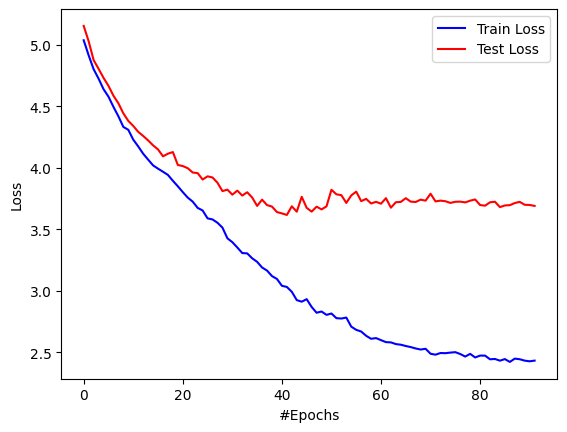

In [62]:
dropout_perc = 0.3
num_layers = 2
hidden_size = 30
network = LSTM_Model(num_layers, hidden_size, dropout_perc)
network = network.to(device)
print("Num. Parameters:", count_parameters(network))

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, cooldown=5, verbose=False)
loss_function = LSTM_MSELoss

batch_size = 800
num_epochs = 201
training_generator = torch.utils.data.DataLoader(trainHittersDataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testHittersDataset, batch_size=batch_size, shuffle=False)

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, scheduler, num_epochs, 10, early_stopping_cutoff=50)

Sanity check

Make sure the model likes good players and doesn't like bad players

In [63]:
paddedHitterInput = torch.nn.utils.rnn.pad_sequence(hitterInput)
hitterLengths = torch.tensor([len(seq) for seq in hitterInput])
network.eval()
network.load_state_dict(torch.load("best_model.pt"))
network = network.to(device)

def GetPlayer(name, id):
    with torch.no_grad():
        for i, hitter in enumerate(hitters):
            if hitter[0] == id:
                idx = i
                break
            
        input = paddedHitterInput[:,idx,:].unsqueeze(0).clone()
        input[:,:,1] = (input[0,0,1] - pickMean) / pickStd
        output = network(input.to(device), hitterLengths[idx].unsqueeze(0).to(device))

        print(name)
        torch.set_printoptions(precision=2, sci_mode=False)
        print(output.squeeze(0).squeeze(1).data)
        print(hitterOutput[idx][0])

In [64]:
GetPlayer("Michael Harrington", 518769)
GetPlayer("Mike Trout", 545361)
GetPlayer("Levi Michael", 605381)
GetPlayer("Bryce Harper", 547180)
GetPlayer("Mike Moustakas", 519058)
GetPlayer("Max Kepler", 596146)

Michael Harrington
tensor([ 0.36,  0.63,  0.58,  0.16, -0.02, -0.06, -0.08, -0.08, -0.09, -0.09,
        -0.12, -0.09, -0.06, -0.05, -0.07, -0.07], device='cuda:0')
tensor([0.])
Mike Trout
tensor([ 1.05,  2.91,  6.32,  7.42,  8.85, 10.24, 10.81, 10.98, 11.05, 11.06,
        11.07, 11.07, 11.08, 11.08, 11.08, 11.07, 11.08], device='cuda:0')
tensor([47.20])
Levi Michael
tensor([     0.80,      2.34,      3.00,      3.36,      3.59,      2.82,
             1.00,      0.61,      0.48,      0.26,      0.13,      0.03,
            -0.00,      0.02,     -0.06,     -0.07,     -0.05,     -0.06,
            -0.05,     -0.06,     -0.08,     -0.06,     -0.07,     -0.08,
            -0.04,     -0.01,     -0.03,     -0.01,     -0.02,     -0.02,
            -0.01,      0.02,      0.03,      0.31,      0.34,      0.38,
             0.41,      0.92,      1.92,      3.16,      2.99],
       device='cuda:0')
tensor([0.])
Bryce Harper
tensor([ 1.09,  4.58,  8.71, 10.39, 10.85, 10.98, 11.01, 11.04, 11.06, 